In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import plot_analysis
from matplotlib.patches import Rectangle


In [3]:
from promised_land import PromisedLandTrader

In [98]:
from analysis import PromisedLandExplorer

# Compare different trading strategies

## Strategy 1 - Koudie

### Inputs

In [4]:
#Read parameters
dict_read_data = {
    "interval":"12h", # Candles of 1 day
    "start_date": "2024-06-01"
                 }

In [5]:
# Signal detection
dict_detect_trades = {
    "rolling_window":7, #Window width in candles of value weighted average price (VWAP)
    "threshold":0.055, #Fraction of deviation from reference metric. (VWAP)
                     }

dict_detect_range = {"rolling_window":np.arange(2,11,2),
                     "threshold":np.round(np.linspace(0.01,0.15,5),3),
                    }

In [6]:
#Trading amounts
dict_trade_logic = {"initial_investment":100,
                    "initial_trade_fraction":0.5,
                    "trade_fraction_cash":0.2, #Fraction of cash value traded
                    "trade_fraction_volume":0.2, #Fraction of unit volume traded
                   }

dict_trade_range = {"trade_fraction_cash":np.round(np.linspace(0.01,0.8,5),3),
                    "trade_fraction_volume":np.round(np.linspace(0.01,0.8,5),3),
                    "initial_trade_fraction":np.round(np.linspace(0.01,1,5),3)
                   }

## Initialisation

In [7]:
koudie = PromisedLandTrader(dict_read_data, 
                            dict_detect_trades,
                            dict_trade_logic,
                            dict_detect_range,
                            dict_trade_range,
                            )

### Performs trades and evaluate strategy

In [8]:
koudie.optimise_strategy()#extract=False)

Progress: 100.00 %

## Best strategies

In [155]:
albi = PromisedLandExplorer(koudie)

In [156]:
albi.pre_process()

### Optimise detections

## Imshow

### Weighted by uncertainty
Detection strategy

In [141]:
df_stat = albi.df_stat_t.groupby(params_trade)["trade_weighted"].mean().to_frame().unstack().droplevel(0,axis=1)

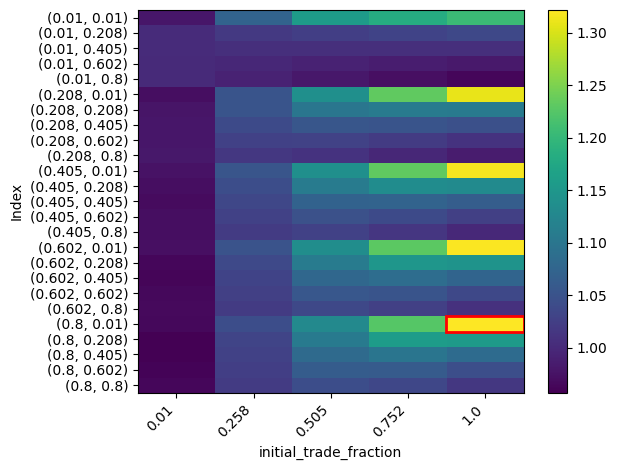

In [142]:
## Weighted by variance, normalised wallet value
plot_analysis.plot_imshow(df_stat)

### Weighted by uncertainty
Trading strategy

In [143]:
df_stat = albi.df_stat_d.groupby(params_detect)["detect_weighted"].mean().to_frame().unstack().droplevel(0,axis=1)

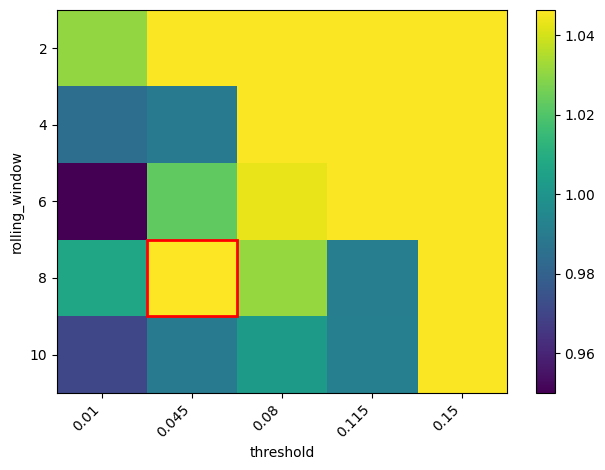

In [144]:
## Weighted by variance, normalised wallet value
plot_analysis.plot_imshow(df_stat)

### Time series

In [260]:
albi = PromisedLandExplorer(koudie)

In [261]:
albi.pre_process()

In [262]:
normalised_wallet = albi.df_ts_norm

In [263]:
normalised_wallet.head()

,normalised_wallet_value_1,normalised_wallet_value_2,normalised_wallet_value_3,normalised_wallet_value_4,normalised_wallet_value_5,timestamp
0,1.000000,1.000000,1.000000,1.000000,1.0,2024-06-01 11:59:59
1,0.998447,0.998836,0.999224,0.999611,1.0,2024-06-01 23:59:59
2,0.991428,0.993575,0.995714,0.997853,1.0,2024-06-02 11:59:59
3,0.998465,0.998850,0.999233,0.999616,1.0,2024-06-02 23:59:59
4,0.979658,0.984754,0.989829,0.994904,1.0,2024-06-03 11:59:59


In [123]:
list_tc = list(df_sp["trade_fraction_cash"].value_counts().index)

In [124]:
list_tv = list(df_sp["trade_fraction_volume"].value_counts().index)

In [125]:
list_tf = list(df_sp["initial_trade_fraction"].value_counts().index)

In [161]:
list_tf

[0.01, 0.258, 0.505, 0.752, 1.0]

In [170]:
mapping, col_name = {}, {}
list_sr = []
mask_detect = (df_sp["rolling_window"]==7) & (df_sp["threshold"]==0.032)
for i in list_tc:
    for j in list_tv:
        for k in list_tf:
            mask = (df_sp["trade_fraction_cash"] == i) & (df_sp['trade_fraction_volume'] == j) & (df_sp["initial_trade_fraction"]==k)
            mapping[(i,j,k)] = df_sp.loc[mask,"coordinate"].values
            
            coordinates = mapping[(i,j,k)]
            col_name[(i,j,k)] = []
            for hc in coordinates:
                col_name[(i,j,k)] += list(df_time_s.columns[df_time_s.columns.str.contains(f'normalised_wallet_value_{hc}$')])

            col = col_name[(i,j,k)][0]
            sr = df_time_s[col].rename(f"({i},{j},{k})")
            list_sr.append(sr)

In [171]:
df_mean = df_time_s[["timestamp"]]
df_mean = df_mean.merge(pd.DataFrame(list_sr).T,  left_index=True, right_index=True)

In [172]:
df_normalised = df_mean[df_mean.columns[1:]].div(df_time_s["normalised_price"], axis=0)
df_normalised = df_normalised.merge(df_time_s[["timestamp"]],  left_index=True, right_index=True)

In [268]:
df_normalised.shape

(1236, 6)

In [264]:
df_normalised = albi.df_ts_norm

In [265]:
col_means = df_normalised.iloc[:, :-1].mean()
examples = df_normalised[pd.concat([col_means.nlargest(5), col_means.nsmallest(5)]).index]

In [266]:
examples = examples.merge(df_time_s[["timestamp"]],  left_index=True, right_index=True)

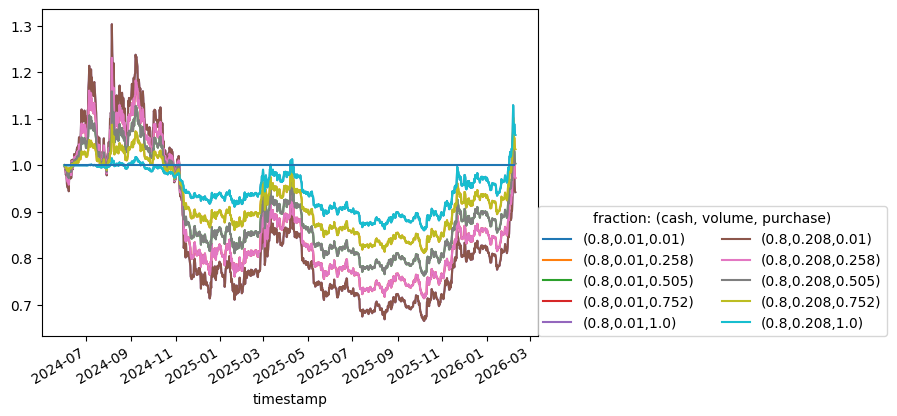

In [267]:
fig, ax = plt.subplots()
# df_time_s.plot(ax=ax,x="timestamp",y="normalised_price", ls=':')
examples.plot(ax=ax,x="timestamp")
plt.legend(df_mean.columns[1:], loc=(1,0), ncols=2, title="fraction: (cash, volume, purchase)")
plt.hlines(1,df_mean["timestamp"].min(),df_mean["timestamp"].max() )
# plt.yscale("log")

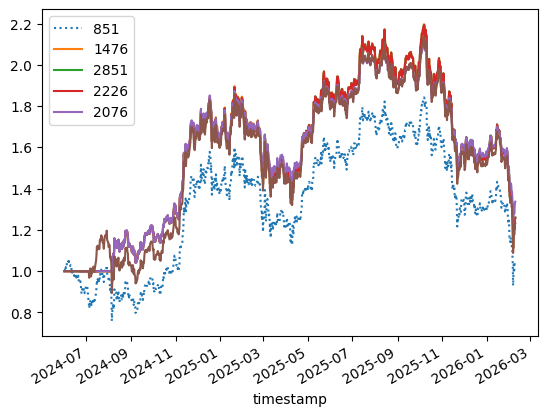

In [38]:
fig, ax = plt.subplots()
df_time_s.plot(ax=ax,x="timestamp",y="normalised_price", ls=':')
df_time_top.plot(ax=ax,x="timestamp", y=normalised_wallet)
plt.legend(highest_comb)

### Show strategy performance

#### Update paramaters with best model

In [39]:
def update_config(self, df, highest_comb):
    params_detect = list(self.detect_config_range.keys())
    params_trade = list(self.trade_config_range.keys())

    dict_ = {"detect": params_detect,
            "trade": params_trade,
            }
    
    for key,params in dict_.items():
        row = df_sp.loc[df_sp["coordinate"]==highest_comb[0],params]
        dict_updated = row.to_dict(orient="records")[0]
        if key == "detect": 
            self.detect_config = self.detect_config | dict_updated
            print(dict_updated)
        elif key=="trade": 
            self.trade_config = self.trade_config | dict_updated
            print(dict_updated)

In [52]:
dict_read_data = {'interval': '12h', 'start_date': '2023'}

dict_detect_trades = {'rolling_window': 12, 'threshold': 0.02}

dict_trade_logic= {'initial_investment': 100,
                     'initial_trade_fraction': 0.5,
                     'trade_fraction_cash': 0.8,
                     'trade_fraction_volume': 0.05,
                  }

In [53]:
goudie = PromisedLandTrader(dict_read_data, 
                            dict_detect_trades,
                            dict_trade_logic,
                            dict_detect_range,
                            dict_trade_range,
                            )

In [54]:
update_config(goudie, df_sp, highest_comb)

{'rolling_window': 4, 'threshold': 0.045}
{'trade_fraction_cash': 0.8, 'trade_fraction_volume': 0.01, 'initial_trade_fraction': 0.01}


In [55]:
goudie.evalaute_strategy()

In [56]:
goudie.df["direction"].value_counts()

direction
 0    2248
-1      15
 1       7
Name: count, dtype: int64

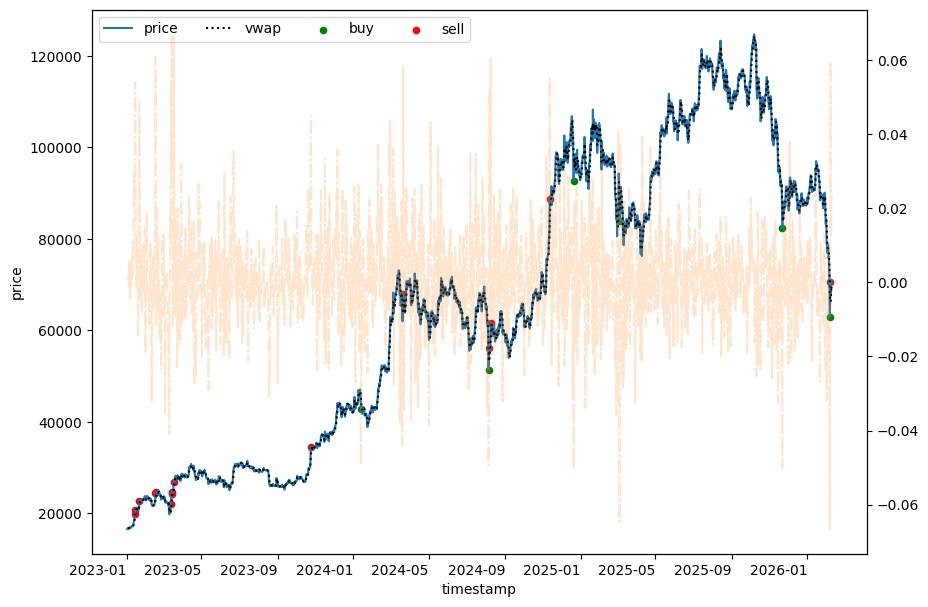

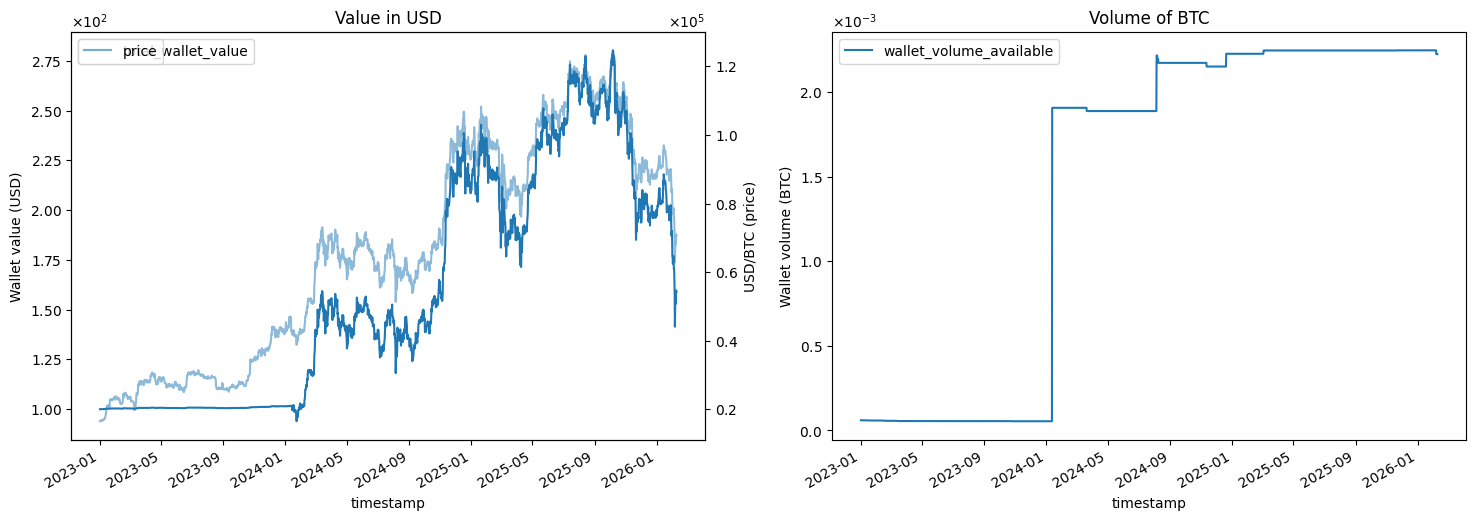

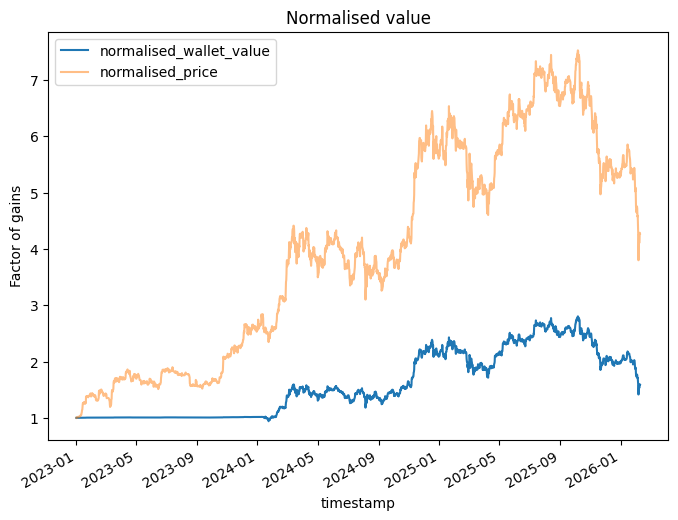

In [57]:
goudie.perform_analysis()

## Consider temporal variance

In [46]:
dict_read_data['interval'] = "12h"
list_nwv = []
for i in np.arange(19,26,1):
    print(f"20{i}")
    dict_read_data["start_date"] = f"20{i}"
    goudie = PromisedLandTrader(dict_read_data, 
                            dict_detect_trades,
                            dict_trade_logic,
                            dict_detect_range,
                            dict_trade_range,
                            )
    goudie.evalaute_strategy()
    list_nwv.append(goudie.df[["timestamp","normalised_wallet_value","normalised_price"]])

2019
2020
2021
2022
2023
2024
2025


In [47]:
df_plot = df_time_s.loc[:,["timestamp"]]
for i,temp in enumerate(list_nwv):
    df_plot = df_plot.merge(temp, on="timestamp", how="outer",suffixes=["",f"_{i}"])

In [48]:
wallet = ["timestamp"]+list(df_plot.columns[df_plot.columns.str.contains("wallet")]) #
price = ["timestamp"]+list(df_plot.columns[df_plot.columns.str.contains("price")]) #

In [49]:
for i, w in enumerate(wallet):
    if w == "timestamp":continue
    df_plot[f"{w}_norm"] = df_plot[w]/df_plot[price[i]]

In [50]:
norm = ["timestamp"]+list(df_plot.columns[df_plot.columns.str.contains("_norm")])

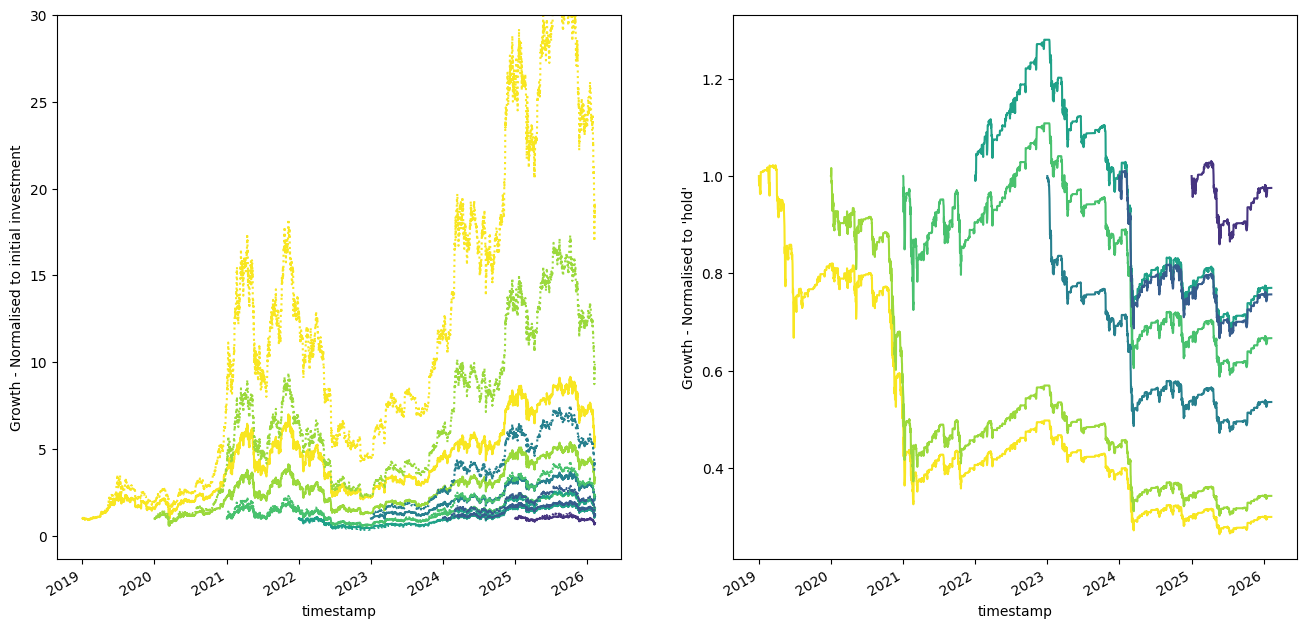

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

cmap = plt.cm.viridis_r
color_vals = cmap(np.linspace(0.01, 0.99, len(wallet)))

df_plot[wallet].plot(ax=ax[0], x="timestamp", color = color_vals, ylabel="Growth - Normalised to initial investment")
df_plot[price].plot(ax=ax[0], x="timestamp", ls=':', color = color_vals)
df_plot[norm].plot(ax=ax[1], x="timestamp", color = color_vals, ylabel="Growth - Normalised to 'hold'")
ax[0].set_ylim(top=30)
ax[0].get_legend().remove()
ax[1].get_legend().remove()
# ax[0].set_yscale("log")
# ax[2].set_label(None)